<a href="https://colab.research.google.com/github/vmondrag/ia/blob/main/Actividad_2_Redes_Neuronales_Convolucionales_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Carga de los datos

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun May 21 11:59:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import cv2
import os
import numpy as np 
import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf



In [3]:
# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets


# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

10658925/10658925 [==============================] - 3s 0us/step


In [4]:
# Descomprimimos el archivo en tmp para visualizar
# !tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /tmp/simpsons

In [4]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [5]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [6]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 60

# ACTIVIDAD 2: REDES NEURONALES CONVOLUCIONALES

---

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


In [7]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [10]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

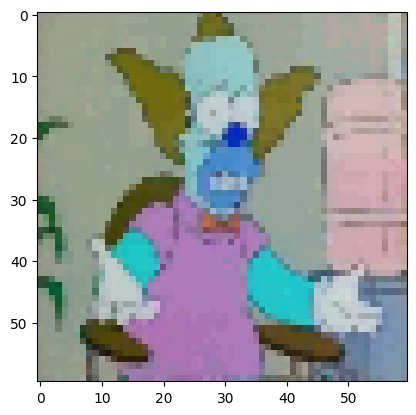

In [11]:
plt.imshow(X_t[2]) # recordad que siempre es preferible trabajar en blanco y negro


# Normalizar el set de datos.

Normalizar los datos es un paso importante en el preprocesamiento de los datos para muchos algoritmos de aprendizaje automático. En este caso, ya que estás trabajando con imágenes y los valores de los píxeles están en el rango de 0 a 255, puedes normalizar los datos simplemente dividiendo por 255.

Aquí hay un ejemplo de cómo hacer esto en tu caso con las variables <b>X</b> y <b>X_t</b> que almacenan tus datos de entrenamiento y de prueba, respectivamente, con el objetivo de que todos los valores en tus conjuntos de datos de entrenamiento y prueba estarán en el rango de 0 a 1.
Es importante destacar que se debe utilizar el método <b>.astype('float32')</b> para asegurarse de que los datos son de tipo float. De lo contrario, si los datos son de tipo int, Python realizará una división de enteros, lo que podría dar como resultado que todos los valores sean 0 o 1 en lugar de un rango de valores entre 0 y 1.

In [12]:
# Normalizar los datos de entrenamiento
#X = X.astype('float32') / 255.0

# Normalizar los datos de prueba
#X_t = X_t.astype('float32') / 255.0


## Ejercicio

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas: 
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

## Información sobre el dataset
1. Número de imágenes de training y de test

In [13]:

print("Número de imágenes de training: ", len(X))
print("Número de imágenes de test: ", len(X_t))

# 2. Tamaño de las imágenes
# El tamaño de las imágenes se puede obtener consultando la forma de cualquier imagen en el dataset.
print("Tamaño de las imágenes: ", X[0].shape)
print("Tamaño de las imágenes test: ", X_t[0].shape)



Número de imágenes de training:  18992
Número de imágenes de test:  890
Tamaño de las imágenes:  (60, 60, 3)
Tamaño de las imágenes test:  (60, 60, 3)


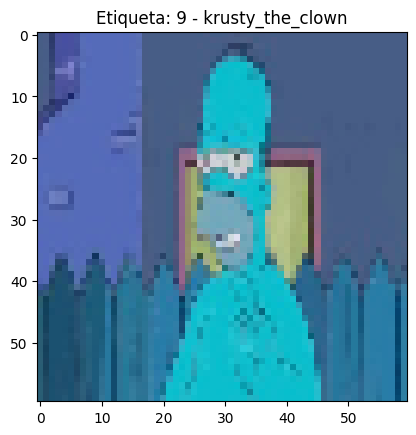

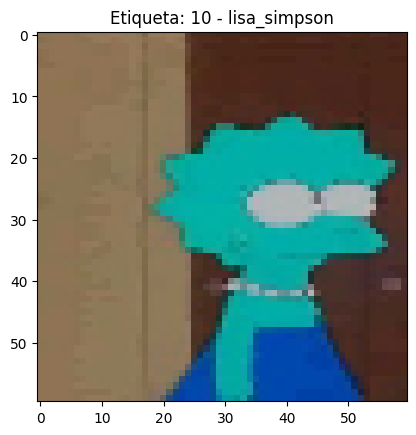

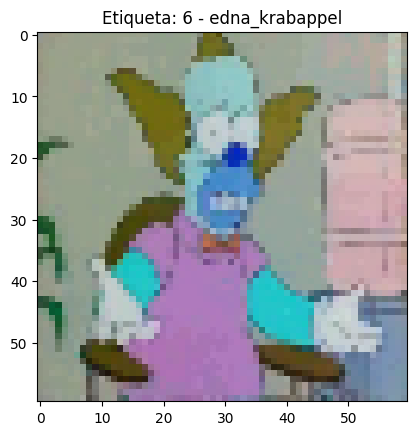

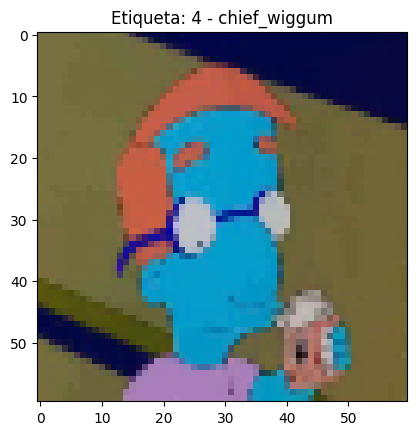

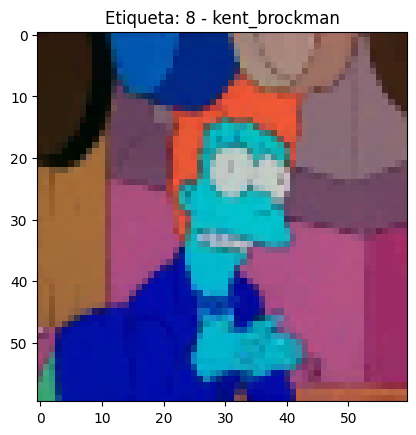

Distribución de etiquetas en el dataset de entrenamiento:  {0: 913, 1: 623, 2: 1342, 3: 1193, 4: 986, 5: 469, 6: 457, 7: 2246, 8: 498, 9: 1206, 10: 1354, 11: 1291, 12: 1079, 13: 1452, 14: 1454, 15: 358, 16: 1194, 17: 877}
Distribución de etiquetas en el dataset de prueba:  {0: 48, 1: 50, 2: 50, 3: 48, 4: 50, 5: 49, 6: 50, 7: 50, 8: 50, 9: 50, 10: 50, 11: 50, 12: 49, 13: 50, 14: 49, 15: 50, 16: 50, 17: 47}


In [14]:

# 3. Exploración de las variables
# Vamos a mostrar las primeras 5 imágenes de entrenamiento con sus correspondientes etiquetas
for i in range(5):
    plt.title(f"Etiqueta: {y[i]} - {MAP_CHARACTERS[y[i]]}")
    plt.imshow(X_t[i],cmap="gray")
    plt.show()


# 4. Descripción de un ejemplo del dataset
# Cada ejemplo del dataset es una imagen de un personaje de los Simpson. 
# Los píxeles de la imagen están representados como una matriz de números, con 3 dimensiones correspondientes a los canales de color rojo, verde y azul (RGB).
# La información en y es una etiqueta de clase, que corresponde a uno de los 18 personajes de los Simpson.

# También podemos explorar la distribución de las etiquetas
unique, counts = np.unique(y, return_counts=True)
print("Distribución de etiquetas en el dataset de entrenamiento: ", dict(zip(unique, counts)))

unique, counts = np.unique(y_t, return_counts=True)
print("Distribución de etiquetas en el dataset de prueba: ", dict(zip(unique, counts)))



**REVISAR -XXXXXXXXX Este código te dará una buena visión general de tus datos. Mostrará el número de imágenes en tus conjuntos de entrenamiento y prueba, el tamaño de tus imágenes, y te permitirá visualizar algunas de tus imágenes de entrenamiento. También proporcionará información sobre la distribución de las etiquetas de clase en tus datos, que puede ser útil para entender si tus clases están balanceadas o no.**



## Normalización 
Primero vamos a preparar nuestros datos de entrada normalizándolos y convirtiendo las etiquetas a formato categórico:

In [15]:
# Normalización: Cambiar el rango de los valores de las imágenes de [0, 255] a [0, 1]
X = X.astype('float32') / 255.0
X_t = X_t.astype('float32') / 255.0

# Convertir las etiquetas a formato categórico
from keras.utils import to_categorical
y_cat = to_categorical(y, num_classes=18)
y_t_cat = to_categorical(y_t, num_classes=18)


## Arquitectura de la CNN.

 Para el propósito de este ejemplo, usaremos una arquitectura sencilla con algunas capas convolucionales, de pooling y de normalización, seguidas por una capa totalmente conectada y una capa de salida softmax:

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()

# Capa Convolucional
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Segunda Capa Convolucional
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Tercera Capa Convolucional
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

# Capa Totalmente Conectada
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Capa de Salida
model.add(Dense(18, activation='softmax'))  # Usamos 18 porque hay 18 clases



## compilar el modelo especificando

Después de definir la arquitectura de la red, debemos compilar el modelo especificando la función de pérdida (usaremos categorical_crossentropy porque es un problema de clasificación multiclase), el optimizador (usaremos adam), y la métrica que queremos rastrear (usaremos accuracy):

In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


## Entrenar el modelo

entrenamos el modelo utilizando nuestros datos. Además, especificamos un conjunto de validación y el número de épocas


In [18]:
history = model.fit(X, y_cat, 
                    validation_split=0.2,  # Usamos el 20% de los datos para validación
                    epochs=30,  # Puedes ajustar este número según los recursos disponibles
                    batch_size=64)  # y este también


Epoch 1/30
238/238 [==============================] - 15s 10ms/step - loss: 2.5448 - accuracy: 0.3170 - val_loss: 2.9205 - val_accuracy: 0.2029
Epoch 2/30
238/238 [==============================] - 2s 7ms/step - loss: 1.7312 - accuracy: 0.4948 - val_loss: 1.8993 - val_accuracy: 0.3888
Epoch 3/30
238/238 [==============================] - 2s 7ms/step - loss: 1.4546 - accuracy: 0.5674 - val_loss: 1.3137 - val_accuracy: 0.6199
Epoch 4/30
238/238 [==============================] - 2s 7ms/step - loss: 1.2450 - accuracy: 0.6283 - val_loss: 1.0527 - val_accuracy: 0.7057
Epoch 5/30
238/238 [==============================] - 2s 7ms/step - loss: 1.1107 - accuracy: 0.6689 - val_loss: 0.9197 - val_accuracy: 0.7373
Epoch 6/30
238/238 [==============================] - 2s 7ms/step - loss: 0.9967 - accuracy: 0.7032 - val_loss: 0.8669 - val_accuracy: 0.7460
Epoch 7/30
238/238 [==============================] - 2s 7ms/step - loss: 0.8960 - accuracy: 0.7241 - val_loss: 0.7764 - val_accuracy: 0.7776
Epoc

## Evaluacíon del Model

Para evaluar tu modelo en el conjunto de test y obtener la pérdida y precisión, puedes usar el método evaluate de tu modelo.
El parámetro verbose controla cuánto detalle presenta durante la evaluación del modelo. 
verbose=0 -Significa no desplegar  ningún detalle de la evaluación 
verbose=1-Si despluiega progreso de la evaluación
Por último, imprime la precisión de la prueba en formato de porcentaje, con 2 decimales de precisión.



In [19]:
test_loss, test_accuracy = model.evaluate(X_t, y_t_cat, verbose=1)
print(f"Test accuracy: {(test_accuracy)*100:.2f}%")


28/28 [==============================] - 0s 5ms/step - loss: 0.2248 - accuracy: 0.9225
Test accuracy: 92.25%


## Validación del Modelo

Cuando se entrena un modelo de aprendizaje automático, es común dividir los datos disponibles en tres conjuntos: entrenamiento, validación y prueba. El conjunto de validación se utiliza para ajustar los parámetros del modelo y seleccionar el mejor modelo durante el proceso de entrenamiento, mientras que el conjunto de prueba se utiliza para obtener una evaluación imparcial del rendimiento final del modelo.

En este caso, ya tienes conjuntos de entrenamiento y prueba (X, y y X_t, y_t, respectivamente). Puedes dividir aún más tu conjunto de entrenamiento en conjuntos de entrenamiento y validación. 

Este código entrena el modelo utilizando el conjunto de entrenamiento y evalúa su rendimiento en el conjunto de validación después de cada época de entrenamiento. Luego evalúa el modelo en el conjunto de validación y imprime la precisión de validación.

Este enfoque te permite controlar el rendimiento del modelo en un conjunto de datos que no se utiliza para el entrenamiento, lo que puede ayudar a detectar problemas como el sobreajuste (cuando el modelo se desempeña bien en el conjunto de entrenamiento pero no en el conjunto de validación) y ajustar los parámetros del modelo en consecuencia.


In [20]:
from sklearn.model_selection import train_test_split

# Dividir el conjunto de entrenamiento en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir las etiquetas a representación categórica
y_train_cat = keras.utils.to_categorical(y_train, num_classes=18)
y_val_cat = keras.utils.to_categorical(y_val, num_classes=18)

# Entrenar el modelo
history = model.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat), batch_size=32, epochs=10)

# Evaluar el rendimiento del modelo en el conjunto de validación
val_loss, val_accuracy = model.evaluate(X_val, y_val_cat, verbose=0)
print(f"Validation accuracy: {(val_accuracy)*100:.2f}%")


Epoch 1/10
475/475 [==============================] - 3s 6ms/step - loss: 0.5061 - accuracy: 0.8480 - val_loss: 0.3395 - val_accuracy: 0.8894
Epoch 2/10
475/475 [==============================] - 3s 6ms/step - loss: 0.4572 - accuracy: 0.8574 - val_loss: 0.2418 - val_accuracy: 0.9326
Epoch 3/10
475/475 [==============================] - 3s 6ms/step - loss: 0.4275 - accuracy: 0.8670 - val_loss: 0.2149 - val_accuracy: 0.9342
Epoch 4/10
475/475 [==============================] - 3s 7ms/step - loss: 0.4123 - accuracy: 0.8702 - val_loss: 0.3334 - val_accuracy: 0.8952
Epoch 5/10
475/475 [==============================] - 3s 6ms/step - loss: 0.3775 - accuracy: 0.8807 - val_loss: 0.2205 - val_accuracy: 0.9345
Epoch 6/10
475/475 [==============================] - 3s 6ms/step - loss: 0.3777 - accuracy: 0.8829 - val_loss: 0.2327 - val_accuracy: 0.9297
Epoch 7/10
475/475 [==============================] - 3s 6ms/step - loss: 0.3564 - accuracy: 0.8892 - val_loss: 0.2076 - val_accuracy: 0.9392
Epoch 

## Prueba con una  nueva imagen.

Primero, necesitas asegurarte de que la nueva imagen se procese de la misma manera que procesaste las imágenes de entrenamiento. En este caso, debes redimensionar la imagen para que sea de 60x60 píxeles, tal como se hizo en el conjunto de datos de entrenamiento. Luego, la imagen se debe normalizar dividiendo los valores de los píxeles por 255 para llevarlos al rango [0, 1].

Después de procesar la imagen, puedes pasarla a través de tu modelo entrenado para obtener las predicciones. Aquí está el código para hacer esto:




1/1 [==============================] - 0s 20ms/step
El personaje predicho es: milhouse_van_houten
abraham_grampa_simpson: 0.00%
apu_nahasapeemapetilon: 0.00%
bart_simpson: 0.02%
charles_montgomery_burns: 0.01%
chief_wiggum: 0.01%
comic_book_guy: 0.00%
edna_krabappel: 0.00%
homer_simpson: 0.09%
kent_brockman: 0.00%
krusty_the_clown: 0.00%
lisa_simpson: 0.04%
marge_simpson: 9.92%
milhouse_van_houten: 87.56%
moe_szyslak: 2.33%
ned_flanders: 0.00%
nelson_muntz: 0.00%
principal_skinner: 0.00%
sideshow_bob: 0.00%

El personaje predicho es: milhouse_van_houten


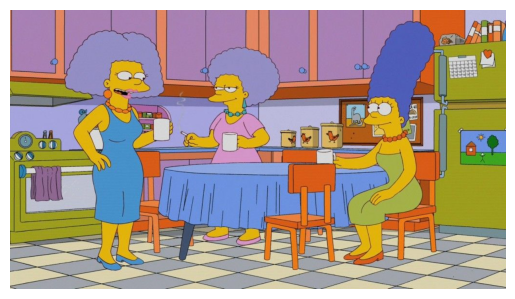

In [24]:
# Cargamos la imagen con cv2

# Primero, bajamos la imagen nueva
keras.utils.get_file(fname="simpsons_prueba01.jpg", 
                     origin="https://cadenaser00.epimg.net/ser/imagenes/2014/12/17/television/1418786070_064451_1418786171_noticia_normal.jpg")

keras.utils.get_file(fname="simpsons_prueba02.jpg", 
                     origin="https://ep00.epimg.net/cultura/imagenes/2012/07/14/album/1342278394_306451_1342283337_album_normal.jpg")

keras.utils.get_file(fname="simpsons_prueba03.jpg", 
                     origin="https://hips.hearstapps.com/es.h-cdn.co/hares/images/cultura/ocio/patty-selma-bouvier-dibujos-animados-los-simpsons-feminismo-solteria-sociedad/3492823-2-esl-ES/patty-y-selma-bouvier-las-hermanas-mas-feministas-de-los-simpsons.jpg")

keras.utils.get_file(fname="simpsons_prueba04.jpg", 
                     origin="https://media.gq.com.mx/photos/5ef7c0d385180fb067834a59/master/w_1600,c_limit/Los-simpson-doblaje-personajes-negros.jpg")

keras.utils.get_file(fname="simpsons_prueba05.jpg", 
                     origin="https://www.actualidadsimpson.com/wp-content/uploads/2020/03/El-Otto-Show-03x22-1.jpg")

keras.utils.get_file(fname="simpsons_prueba06.jpg", 
                     origin="https://i0.wp.com/www.lacasadeel.net/wp-content/uploads/2021/12/Homer-hospital.jpg")





image_path = '/root/.keras/datasets/simpsons_prueba03.jpg'  # Reemplaza por la ruta de tu imagen
image = cv2.imread(image_path)

# Redimensionamos la imagen a 60x60
image = cv2.resize(image, (60, 60))

# Normalizamos los valores de los píxeles
image = image / 255.0

# Añadimos una dimensión extra al inicio para indicar el número de imágenes (1 en este caso)
# ya que el modelo espera esta dimensión
image = np.expand_dims(image, axis=0)

# Usamos el modelo para obtener las predicciones
predictions = model.predict(image)

# La salida del modelo es un vector de probabilidades para cada clase, por lo que 
# tomamos el índice con la mayor probabilidad para obtener la clase predicha
predicted_class = np.argmax(predictions[0])

# Imprimimos el personaje de los Simpsons predicho por el modelo
print('El personaje predicho es:', MAP_CHARACTERS[predicted_class])



# Imprimimos las probabilidades de cada clase
for name, prob in zip(MAP_CHARACTERS.values(), predictions[0]):
    print(f'{name}: {prob*100:.2f}%')

# Tomamos el índice con la mayor probabilidad para obtener la clase predicha
predicted_class = np.argmax(predictions[0])

# Imprimimos el personaje de los Simpsons predicho por el modelo
print('\nEl personaje predicho es:', MAP_CHARACTERS[predicted_class])

# Mostramos la imagen
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()
